In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pkg_resources

from debvader.debvader import load_deblender, deblend, deblend_field, iterative_deblending


2021-12-10 12:29:11.765224: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2021-12-10 12:29:11.767000: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2021-12-10 12:29:11.767046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [2]:
data_folder_path = pkg_resources.resource_filename('debvader', "data/")
image_path = os.path.join(data_folder_path + 'dc2_imgs/imgs_dc2.npy')
images = np.load(image_path, mmap_mode = 'c')

Visualize some of the images

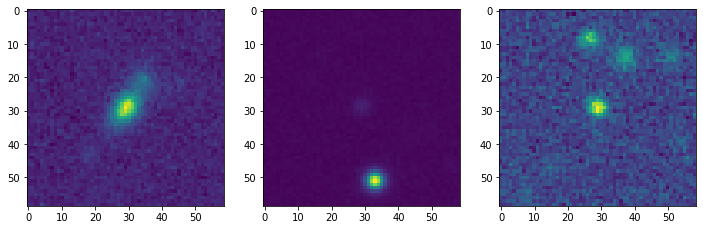

In [3]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [5]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(survey, input_shape, latent_dim, filters, kernels, return_encoder_decoder_z=True)

2021-12-10 12:29:43.479284: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2021-12-10 12:29:43.479454: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 12:29:43.479588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2021-12-10 12:29:43.483685: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-12-10 12:29:43.511511: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2399995000 Hz
2021-12-10 12:29:43.515383: I tensorflow/compiler/xla/service/service.cc

in cropping
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


2021-12-10 12:29:45.180008: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


/pbs/throng/lsst/users/bbiswas/debvader/debvader/data/weights/dc2/not_normalised/loss/


In [6]:
# We can visualize the network
net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
model (Model)                (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 32), (None, 32))  0         
_________________________________________________________________
model_1 (Model)              (None, 59, 59, 6)         4577228   
Total params: 8,318,452
Trainable params: 3,741,212
Non-trainable params: 4,577,240
_________________________________________________________________


We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [7]:
output_images_mean, output_images_distribution = deblend(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

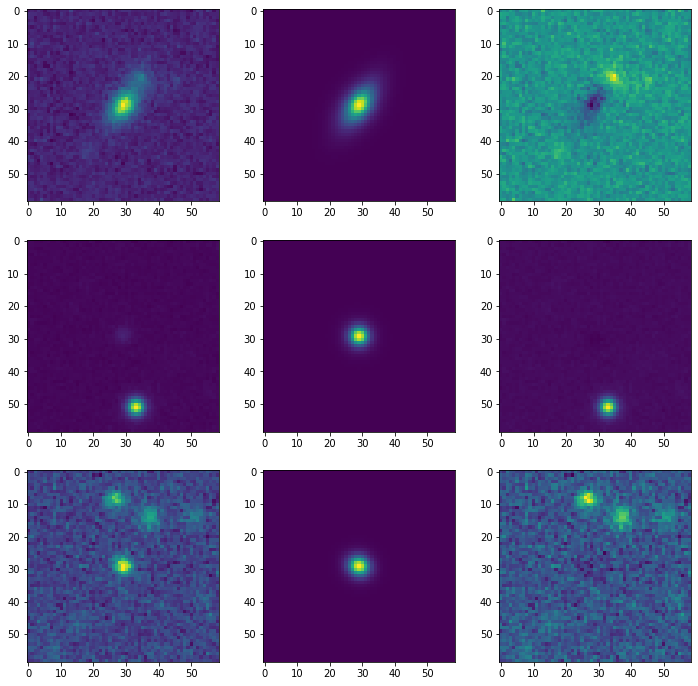

In [8]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

In [9]:
import pandas as pd
root_dir = "/pbs/home/b/barcelin/sps_link/data/dc2_test/24.5/test/"

images_noiseless = np.load(root_dir+'img_noiseless_sample_2.npy', mmap_mode = 'c')
images_noisy = np.load(root_dir+'img_cropped_sample_2.npy', mmap_mode = 'c')
data = pd.read_csv(root_dir+'img_noiseless_data_2.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/pbs/home/b/barcelin/sps_link/data/dc2_test/24.5/test/img_noiseless_sample_2.npy'

In [ ]:
latent_space_distribution_noiseless = z(tf.cast(images_noiseless[:1000], tf.float32))
latent_space_distribution_noisy = z(tf.cast(images_noisy[:1000], tf.float32))

#print(latent_space_distribution)

In [ ]:
plt.plot(np.linspace(0,32, 32), np.mean(latent_space_distribution_noiseless.stddev().numpy() ,axis = 0), '.', color = 'blue', alpha = 0.3)
plt.plot(np.linspace(0,32, 32), np.mean(latent_space_distribution_noiseless.stddev().numpy() ,axis = 0), '.', color = 'red', alpha = 0.3)

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noiseless.stddev().numpy(), axis = 0), bins = 100, alpha = 0.3 , label = 'noiseless')
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noisy.stddev().numpy(), axis = 0), bins = 100, alpha = 0.3, label = 'blended and noisy')

axes[0].legend()
axes[1].set_xlim(0, 0.8)
axes[1].set_ylim(0, 1000)

plt.title('standard deviation of latent space')

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noiseless.mean().numpy(), axis = 0), bins = 100, alpha = 0.3 , label = 'noiseless')
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noisy.mean().numpy(), axis = 0), bins = 100, alpha = 0.3, label = 'blended and noisy')

axes[0].legend()
axes[1].set_xlim(-5, 5)
axes[1].set_yscale('log')

plt.title('means of latent space')

Now let's visualise as a function of blendedness

In [ ]:
latent_space_distribution_noiseless.stddev().numpy().shape

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
        _ = axes[i].plot(data['blendedness'][:1000], np.mean(latent_space_distribution_noiseless.stddev().numpy(), axis = 1), '.',color = 'blue', alpha = 0.3 , label = 'noiseless')
        _ = axes[i].plot(data['blendedness'][:1000], np.mean(latent_space_distribution_noisy.stddev().numpy(), axis = 1),'.', color = 'red', alpha = 0.3 , label = 'noisy')

axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('mean std in latent space as a function of blendedness')

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [ ]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

In [ ]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean flux')
    axes[i,2].set_title('output std of flux per pixel')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')